**Projet de reconnaissance de pokemon**

On va donc chercher à classifier des pokemons, c'est à dire reconnaitre sur une image de quel pokemon il s'agit.



Premiérement importons les différents module nécessaires.

In [1]:
import torch
import numpy as np
import os
import torchvision
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

Récuperons le nombre de classes (ie de pokemon), ainsi que les différents labels.

In [2]:
labels_list=os.listdir('PokemonData') #on récupere les labels qui correspondent au nom des différents pokemon
nb_classes=len(labels_list)
print(f'on a donc {nb_classes} classes')
print(labels_list)


on a donc 150 classes
['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 

**Transfert d'apprentissage**

Normalisons les données ainsi que mettons les dans un data loader


In [3]:
path='PokemonData'
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_transforms = transforms.Compose([
    transforms.Resize([150, 150]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset_full = datasets.ImageFolder(path, data_transforms)
print(len(dataset_full))

6820


On sépare en train test val (60/25/15) et on prépare les différents dataloaders

In [34]:
np.random.seed(42)

samples_train, samples_test = train_test_split(dataset_full.samples)
samples_train, samples_val = train_test_split(samples_train,test_size=0.2)

dataset_train = datasets.ImageFolder(path, data_transforms)
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4) #choix de la batch size ici

dataset_val = datasets.ImageFolder(path, data_transforms)
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

dataset_test = datasets.ImageFolder(path, data_transforms)
dataset_test.samples = samples_test
dataset_test.imgs = samples_test
print(len(dataset_full.samples))
print(len(dataset_test.samples))


6820
1705


Pour utiliser une carte graphique amd pour les calculs

In [35]:
device ="dml"

On définit les fonctions de train et d'évaluation

In [36]:
def evaluate(model, dataset):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)

PRINT_LOSS = True
def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=10):
    train_losses=[]
    train_accuracy=[]
    val_accuracy=[]
    val_loss=[]
    for epoch in range(n_epochs): # à chaque epochs
        running_loss = 0.0
        running_accuracy=0
        
        
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train): # itère sur les minibatchs via le loader apprentissage
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # on passe les données GPU
            optimizer.zero_grad() # on réinitialise les gradients
            outputs = model(inputs) # on calcule l'output           
            loss = criterion(outputs, labels) # on calcule la loss
            _, preds = torch.max(outputs, 1)
            n_correct = torch.sum(preds == labels)
            running_loss+=loss.item() #pour récuperer de quoi tracer des courbes
            running_accuracy+=n_correct
        
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(model, data_val)
                model.train(True)
                print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))

        
            loss.backward() # on effectue la backprop pour calculer les gradients
            optimizer.step() # on update les gradients en fonction des paramètres
        
        epoch_loss=running_loss/len(loader_train)
        epoch_accuracy=float(running_accuracy)/len(loader_train)

        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        val_accuracy.append(accuracy)
        val_loss.append(loss_val)
    return train_losses,train_accuracy,val_accuracy,val_loss



on récupere le model resnet-18

In [51]:
print("Récupération du ResNet-18 pré-entraîné...")
my_net = models.resnet18(pretrained=True)



Récupération du ResNet-18 pré-entraîné...


In [52]:
my_net.fc = nn.Linear(in_features=my_net.fc.in_features, out_features=nb_classes, bias=True)
my_net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
params_to_update = my_net.parameters()

On définit ici la loss et l'optimiseur (soit adam soit SGD avec les hyper paramètres que l'on souhaite(se référer au rapport pour les paramétres optimals))

In [54]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(params_to_update, lr=0.0001, weight_decay=1e-5)
optimizer=optim.SGD(params_to_update, lr=0.001,momentum=0.9) 

In [55]:
print("Apprentissage avec fine-tuning")
my_net.train(True)
torch.manual_seed(42)
train_losses,train_accuracy,val_accuracy,val_loss=train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=7)

# on évalue les performances
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

Apprentissage avec fine-tuning
EPOCH  0
0 loss train: 5.2876	 val 0.3411	Acc (val): 0.5%
1 loss train: 5.5108	 val 0.3403	Acc (val): 0.6%
2 loss train: 5.3024	 val 0.3394	Acc (val): 0.3%
3 loss train: 5.3700	 val 0.3384	Acc (val): 0.4%
4 loss train: 5.3225	 val 0.3374	Acc (val): 0.4%
5 loss train: 5.2470	 val 0.3364	Acc (val): 0.4%
6 loss train: 5.2802	 val 0.3351	Acc (val): 0.5%
7 loss train: 5.3955	 val 0.3341	Acc (val): 0.4%
8 loss train: 5.3008	 val 0.3330	Acc (val): 0.3%
9 loss train: 5.1932	 val 0.3318	Acc (val): 0.2%
10 loss train: 5.2547	 val 0.3307	Acc (val): 0.3%
11 loss train: 5.1364	 val 0.3296	Acc (val): 0.3%
12 loss train: 5.0476	 val 0.3287	Acc (val): 0.4%
13 loss train: 5.3766	 val 0.3276	Acc (val): 0.5%
14 loss train: 5.3029	 val 0.3265	Acc (val): 0.5%
15 loss train: 5.1188	 val 0.3255	Acc (val): 0.6%
16 loss train: 5.1453	 val 0.3245	Acc (val): 0.6%
17 loss train: 5.1146	 val 0.3234	Acc (val): 0.5%
18 loss train: 5.2673	 val 0.3225	Acc (val): 0.7%
19 loss train: 5.064

(voir rapport pour les différents résultats en fonctions des différents paramétres)

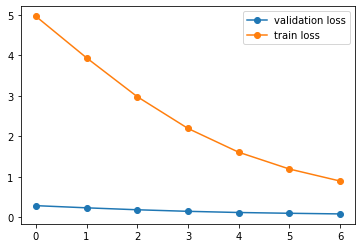

In [56]:

plt.plot(val_loss, "-o", label='validation loss')
plt.plot(train_losses, "-o", label='train loss')
plt.legend()
plt.show()




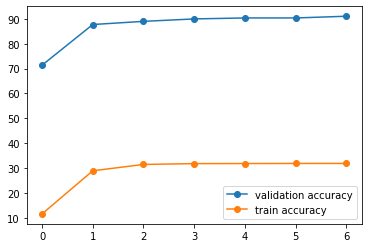

l'accuracy sur le test est de:  92.43401759530792


In [15]:
val_accuracy_good=[acc*100 for acc in val_accuracy]
plt.plot(val_accuracy_good, "-o", label='validation accuracy')
plt.plot(train_accuracy, "-o", label='train accuracy')
plt.legend()
plt.show()
print("l'accuracy sur le test est de: ",accuracy*100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pokémon : Pidgey
prédiction : Pidgey


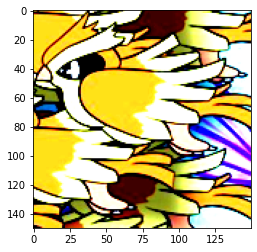

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pokémon : Doduo
prédiction : Doduo


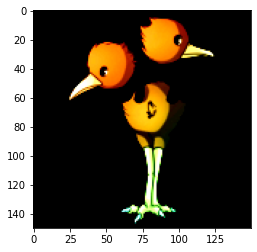

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pokémon : Fearow
prédiction : Fearow


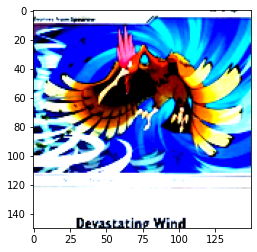

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pokémon : Omastar
prédiction : Omastar


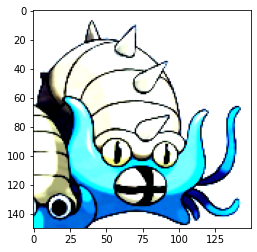

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pokémon : Pikachu
prédiction : Pikachu


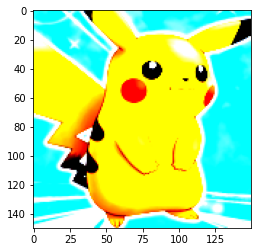

In [76]:
import random
def random_image_from_test(dataset) :
    copy_test=dataset.samples.copy()
    list_affichage=[]
    for k in range(5) :
        rdm_nbr=random.randint(0,len(copy_test)-1)
        list_affichage.append(copy_test[rdm_nbr])
    return list_affichage

list_aff=random_image_from_test(dataset_test)
dataset_test_affichage=datasets.ImageFolder(path, data_transforms)
dataset_test_affichage.samples=list_aff
dataset_test_affichage.imgs=list_aff

def plot_image(images) :
    plt.imshow(np.transpose(images[0].cpu().detach().numpy(), (1, 2, 0)))
    plt.show()

def affichage(dataset,model, list_aff,list_label) :
    model.train(False)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        print('pokémon :',list_label[labels.item()])
        _, preds = torch.max(outputs, 1)
        print('prédiction :',list_label[preds.item()])
        
        plt.imshow(np.transpose(inputs[0].cpu().detach().numpy(), (1, 2, 0)))
        
        plt.show()

        

affichage(dataset_test_affichage,my_net,list_aff,labels_list)

        
    



On sauvegarde le modéle sur le cpu et on le load sur le gpu après.

In [90]:
my_net.to('cpu')
torch.save(my_net.state_dict(), 'state_dict.pth')

In [18]:
#my_net.load_state_dict(torch.load('state_dict.pth'))
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

Accuracy (test): 89.6%
